# 🤖 AI Face Emotion Detection - Model Retraining

This notebook retrains the emotion detection model using user feedback data collected from the app.

## Workflow:
1. **Load Feedback Data** - From CSV and images
2. **Visualize Data** - Check what was corrected
3. **Fine-tune Model** - Retrain with feedback
4. **Evaluate Performance** - Compare old vs new
5. **Update Model** - Replace original with improved version

In [69]:
# Import Required Libraries
import os
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 📁 Configuration

Set up paths and emotion labels.

In [70]:
# Configuration
import os

# Get the current working directory (where the notebook is)
BASE_DIR = os.getcwd()
FEEDBACK_CSV = os.path.join(BASE_DIR, "feedback_log.csv")
FEEDBACK_IMAGES_DIR = os.path.join(BASE_DIR, "feedback_images")
MODEL_PATH = os.path.join(BASE_DIR, "best_emotion_model.keras")
RETRAINED_MODEL_PATH = os.path.join(BASE_DIR, "best_emotion_model_retrained.keras")

EMOTION_LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

print(f"📂 Feedback CSV: {FEEDBACK_CSV}")
print(f"📂 Images Directory: {FEEDBACK_IMAGES_DIR}")
print(f"📂 Model Path: {MODEL_PATH}")

📂 Feedback CSV: c:\Users\moham\OneDrive\Desktop\AI-face-emotion-detaction\project\feedback_log.csv
📂 Images Directory: c:\Users\moham\OneDrive\Desktop\AI-face-emotion-detaction\project\feedback_images
📂 Model Path: c:\Users\moham\OneDrive\Desktop\AI-face-emotion-detaction\project\best_emotion_model.keras


## 📊 Load & Analyze Feedback Data

Load the feedback data and visualize what users corrected.

In [71]:
# Load feedback CSV
if not os.path.exists(FEEDBACK_CSV):
    print("❌ No feedback data found. Run the app first to collect feedback.")
else:
    # Read CSV
    df = pd.read_csv(FEEDBACK_CSV)
    print(f"📄 Total rows in CSV: {len(df)}")
    
    # Show original data before cleaning
    print(f"\n🔍 Original data preview:")
    print(df.head())
    
    # Clean data - remove rows with missing critical data
    initial_count = len(df)
    df = df.dropna(subset=['image_path', 'corrected_emotion'])
    print(f"\n✂️ Removed {initial_count - len(df)} rows with missing image_path or corrected_emotion")
    
    # Convert confidence to float if it's not already
    df['confidence'] = pd.to_numeric(df['confidence'], errors='coerce')
    
    # Convert timestamp - handle multiple date formats
    # Try standard format first, then custom format
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', errors='coerce')
    
    # Count how many timestamps failed to parse
    failed_timestamps = df['timestamp'].isna().sum()
    if failed_timestamps > 0:
        print(f"⚠️  Warning: {failed_timestamps} timestamps could not be parsed")
        print(f"   Rows with failed timestamps will be kept but timestamp set to NaT")
    
    # Don't drop rows with invalid timestamps - just warn about them
    # This allows us to use the image data even if timestamp parsing fails
    
    print(f"\n✅ Successfully loaded {len(df)} feedback records")
    print(f"   - Valid timestamps: {len(df) - failed_timestamps}")
    print(f"   - Invalid timestamps: {failed_timestamps}")
    
    display(df)

📄 Total rows in CSV: 50

🔍 Original data preview:
        timestamp predicted_emotion  confidence corrected_emotion  \
0  2/27/2026 5:01             Happy         1.0             Happy   
1  2/27/2026 5:01             Happy         1.0             Happy   
2  2/27/2026 5:02             Happy         1.0             Happy   
3  2/27/2026 5:02             Happy         1.0             Happy   
4  2/27/2026 5:02             Happy         1.0             Happy   

                                  image_path                        image_hash  
0  20260227_050117_709347_Happy_to_Happy.png  e770565c3cc461161cf90bae58329fd6  
1  20260227_050128_170551_Happy_to_Happy.png  0c6481b254e1a33f78070ae4123d412b  
2  20260227_050213_912159_Happy_to_Happy.png  b39829456160225e7de43323e7377b8e  
3  20260227_050220_860116_Happy_to_Happy.png  92d3805b7b33f610bc4ea04fba393463  
4  20260227_050233_370555_Happy_to_Happy.png  aaeb5a219402872d3f5983f5324e70d7  

✂️ Removed 0 rows with missing image_path or cor

,timestamp,predicted_emotion,confidence,corrected_emotion,image_path,image_hash
0,2026-02-27 05:01:00,Happy,1.0000,Happy,20260227_050117_709347_Happy_to_Happy.png,e770565c3cc461161cf90bae58329fd6
1,2026-02-27 05:01:00,Happy,1.0000,Happy,20260227_050128_170551_Happy_to_Happy.png,0c6481b254e1a33f78070ae4123d412b
2,2026-02-27 05:02:00,Happy,1.0000,Happy,20260227_050213_912159_Happy_to_Happy.png,b39829456160225e7de43323e7377b8e
3,2026-02-27 05:02:00,Happy,1.0000,Happy,20260227_050220_860116_Happy_to_Happy.png,92d3805b7b33f610bc4ea04fba393463
4,2026-02-27 05:02:00,Happy,1.0000,Happy,20260227_050233_370555_Happy_to_Happy.png,aaeb5a219402872d3f5983f5324e70d7
5,2026-02-27 05:02:00,Angry,1.0000,Angry,20260227_050240_527462_Angry_to_Angry.png,9d401096ed40cd52b3b87aff7c776461
6,2026-02-27 05:02:00,Angry,0.9055,Angry,20260227_050251_965332_Angry_to_Angry.png,13a245aa1e091da477533a38b47a235d
7,2026-02-27 05:03:00,Angry,0.8645,Angry,20260227_050305_062970_Angry_to_Angry.png,d55dad53a0caa8bdadb4bbb46f75dcb4
8,2026-02-27 05:03:00,Angry,0.9170,Angry,20260227_050311_922423_Angry_to_Angry.png,364f6b182e16c471d668e7538c5490f7
9,2026-02-27 05:03:00,Sad,0.4641,Fear,20260227_050329_185278_Sad_to_Fear.png,70f649054f3e141f12213b3e46cedc26


### 📈 Visualize Feedback Statistics

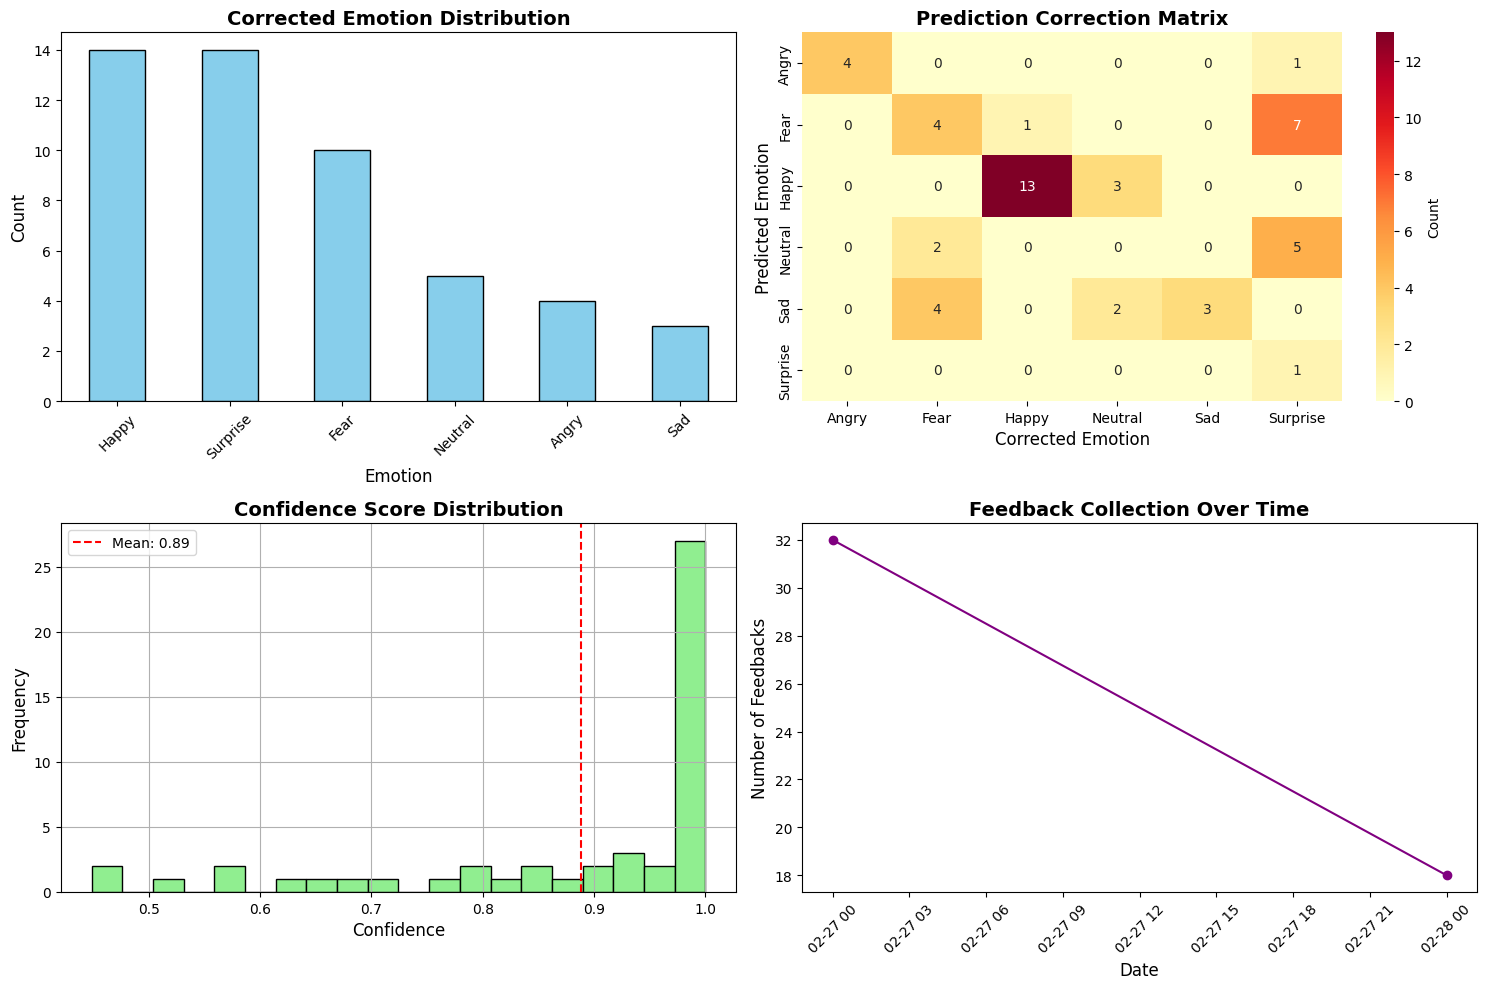


📊 Summary Statistics:
   Total feedbacks: 50
   Average confidence: 0.8883
   Date range: 2026-02-27 05:01:00 to 2026-02-28 17:32:13


In [72]:
# Visualize feedback statistics
if 'df' not in locals() or df is None or len(df) == 0:
    print("❌ No feedback data loaded. Please run the previous cell first.")
else:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Predicted vs Corrected Emotions
    ax1 = axes[0, 0]
    emotion_counts = df['corrected_emotion'].value_counts()
    emotion_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
    ax1.set_title('Corrected Emotion Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Emotion', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)

    # 2. Correction matrix (predicted -> corrected)
    ax2 = axes[0, 1]
    correction_matrix = pd.crosstab(df['predicted_emotion'], df['corrected_emotion'])
    sns.heatmap(correction_matrix, annot=True, fmt='d', cmap='YlOrRd', ax=ax2, cbar_kws={'label': 'Count'})
    ax2.set_title('Prediction Correction Matrix', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Corrected Emotion', fontsize=12)
    ax2.set_ylabel('Predicted Emotion', fontsize=12)

    # 3. Confidence distribution
    ax3 = axes[1, 0]
    df['confidence'].hist(bins=20, ax=ax3, color='lightgreen', edgecolor='black')
    ax3.set_title('Confidence Score Distribution', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Confidence', fontsize=12)
    ax3.set_ylabel('Frequency', fontsize=12)
    ax3.axvline(df['confidence'].mean(), color='red', linestyle='--', label=f'Mean: {df["confidence"].mean():.2f}')
    ax3.legend()

    # 4. Feedbacks over time
    ax4 = axes[1, 1]
    df.groupby(df['timestamp'].dt.date).size().plot(kind='line', marker='o', ax=ax4, color='purple')
    ax4.set_title('Feedback Collection Over Time', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Date', fontsize=12)
    ax4.set_ylabel('Number of Feedbacks', fontsize=12)
    ax4.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    print(f"\n📊 Summary Statistics:")
    print(f"   Total feedbacks: {len(df)}")
    print(f"   Average confidence: {df['confidence'].mean():.4f}")
    print(f"   Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

### 🖼️ Display Sample Feedback Images

View some of the images that were corrected.

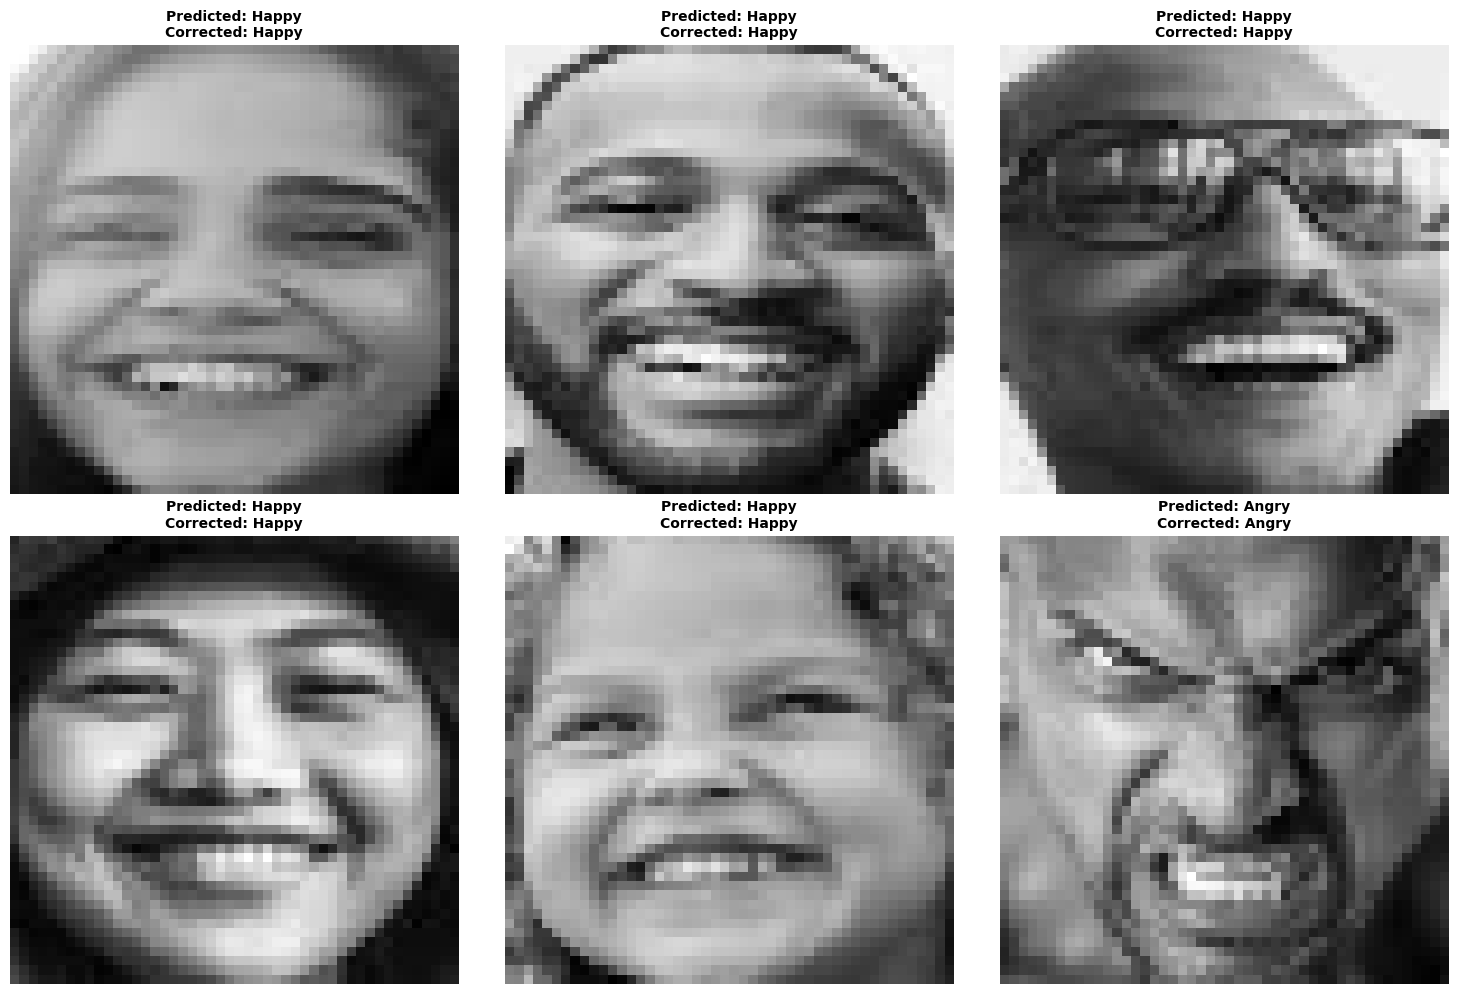

In [73]:
# Display sample feedback images
if 'df' not in locals() or df is None or len(df) == 0:
    print("❌ No feedback data loaded. Please run the previous cells first.")
else:
    num_samples = min(6, len(df))
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx in range(num_samples):
        row = df.iloc[idx]
        image_path = os.path.join(FEEDBACK_IMAGES_DIR, row['image_path'])
        
        if os.path.exists(image_path):
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                axes[idx].imshow(img, cmap='gray')
                axes[idx].set_title(f"Predicted: {row['predicted_emotion']}\nCorrected: {row['corrected_emotion']}", 
                                   fontsize=10, fontweight='bold')
            else:
                axes[idx].text(0.5, 0.5, 'Failed to Load', ha='center', va='center')
            axes[idx].axis('off')
        else:
            axes[idx].text(0.5, 0.5, 'Image Not Found', ha='center', va='center')
            axes[idx].axis('off')

    # Hide empty subplots
    for idx in range(num_samples, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

## 🔄 Load Feedback Data for Training

Prepare images and labels for model retraining.

In [74]:
# Load feedback data
if 'df' not in locals() or df is None or len(df) == 0:
    print("❌ No feedback data loaded. Please run the previous cells first.")
    X = None
    y = None
else:
    X = []  # Images
    y = []  # Labels

    for idx, row in df.iterrows():
        image_filename = str(row['image_path']).strip()
        correct_emotion = str(row['corrected_emotion']).strip()
        
        image_path = os.path.join(FEEDBACK_IMAGES_DIR, image_filename)
        
        if os.path.exists(image_path):
            # Load image
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = img / 255.0  # Normalize
                X.append(img)
                y.append(EMOTION_LABELS.index(correct_emotion))
                print(f"  ✅ Loaded: {image_filename} → {correct_emotion}")
            else:
                print(f"  ❌ Failed to load: {image_filename}")
        else:
            print(f"  ❌ Image not found: {image_path}")

    if len(X) == 0:
        print("\n❌ No valid images loaded!")
        X = None
        y = None
    else:
        # Convert to numpy arrays
        X = np.array(X)
        y = np.array(y)

        # Reshape for model input (batch, height, width, channels)
        X = X.reshape(-1, 48, 48, 1)

        print(f"\n📊 Data Summary:")
        print(f"   Total samples: {len(X)}")
        print(f"   Shape: {X.shape}")
        print(f"   Labels shape: {y.shape}")
        print(f"   Min/Max pixel values: {X.min():.2f} / {X.max():.2f}")

  ✅ Loaded: 20260227_050117_709347_Happy_to_Happy.png → Happy
  ✅ Loaded: 20260227_050128_170551_Happy_to_Happy.png → Happy
  ✅ Loaded: 20260227_050213_912159_Happy_to_Happy.png → Happy
  ✅ Loaded: 20260227_050220_860116_Happy_to_Happy.png → Happy
  ✅ Loaded: 20260227_050233_370555_Happy_to_Happy.png → Happy
  ✅ Loaded: 20260227_050240_527462_Angry_to_Angry.png → Angry
  ✅ Loaded: 20260227_050251_965332_Angry_to_Angry.png → Angry
  ✅ Loaded: 20260227_050305_062970_Angry_to_Angry.png → Angry
  ✅ Loaded: 20260227_050311_922423_Angry_to_Angry.png → Angry
  ✅ Loaded: 20260227_050329_185278_Sad_to_Fear.png → Fear
  ✅ Loaded: 20260227_050415_607809_Fear_to_Fear.png → Fear
  ✅ Loaded: 20260227_050426_979515_Neutral_to_Surprise.png → Surprise
  ✅ Loaded: 20260227_050443_523238_Happy_to_Happy.png → Happy
  ✅ Loaded: 20260227_050455_620996_Neutral_to_Surprise.png → Surprise
  ✅ Loaded: 20260227_050510_436488_Fear_to_Surprise.png → Surprise
  ✅ Loaded: 20260227_050517_836490_Happy_to_Happy.png → 

## 🧠 Load Original Model

Load the current model that will be fine-tuned.

In [75]:
# Load original model
print("🔄 Loading original model...")
model = load_model(MODEL_PATH)

print("\n📈 Model Architecture:")
model.summary()

🔄 Loading original model...

📈 Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,162,327 (80.73 MB)

 Trainable params: 7,052,487 (26.90 MB)

 Non-trainable params: 4,864 (19.00 KB)

 Optimizer params: 14,104,976 (53.81 MB)

## 🚀 Fine-Tune Model with Feedback Data

Retrain the model with data augmentation to improve generalization.

In [76]:
# Compile model with lower learning rate for fine-tuning
if X is None or y is None:
    print("❌ No training data available. Please run the previous cells first.")
else:
    optimizer = Adam(learning_rate=0.0001)  # Lower learning rate for fine-tuning
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Data augmentation to improve generalization
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        fill_mode='nearest'
    )

    print("🚀 Starting fine-tuning...")
    print(f"   Epochs: 10")
    print(f"   Batch size: 8")
    print(f"   Samples: {len(X)}")
    print(f"   Learning rate: 0.0001\n")

    # Fine-tune with the feedback data
    history = model.fit(
        datagen.flow(X, y, batch_size=8),
        epochs=10,
        verbose=1,
        steps_per_epoch=max(1, len(X) // 8)
    )

    print("\n✅ Fine-tuning complete!")

🚀 Starting fine-tuning...
   Epochs: 10
   Batch size: 8
   Samples: 50
   Learning rate: 0.0001

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 334ms/step - accuracy: 0.2619 - loss: 2.3499
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2500 - loss: 3.2639  
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - accuracy: 0.3333 - loss: 2.1211
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5000 - loss: 2.1003  
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - accuracy: 0.3095 - loss: 1.8887
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3750 - loss: 2.2510  
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - accuracy: 0.3958 - loss: 2.2142
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 2.6269  
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 316ms/step - accuracy: 0.4792 - loss: 1.5091
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5000 - loss: 2.4502  

✅ Fine-tuning complete!


## 📊 Visualize Training Results

Plot the training loss and accuracy curves.

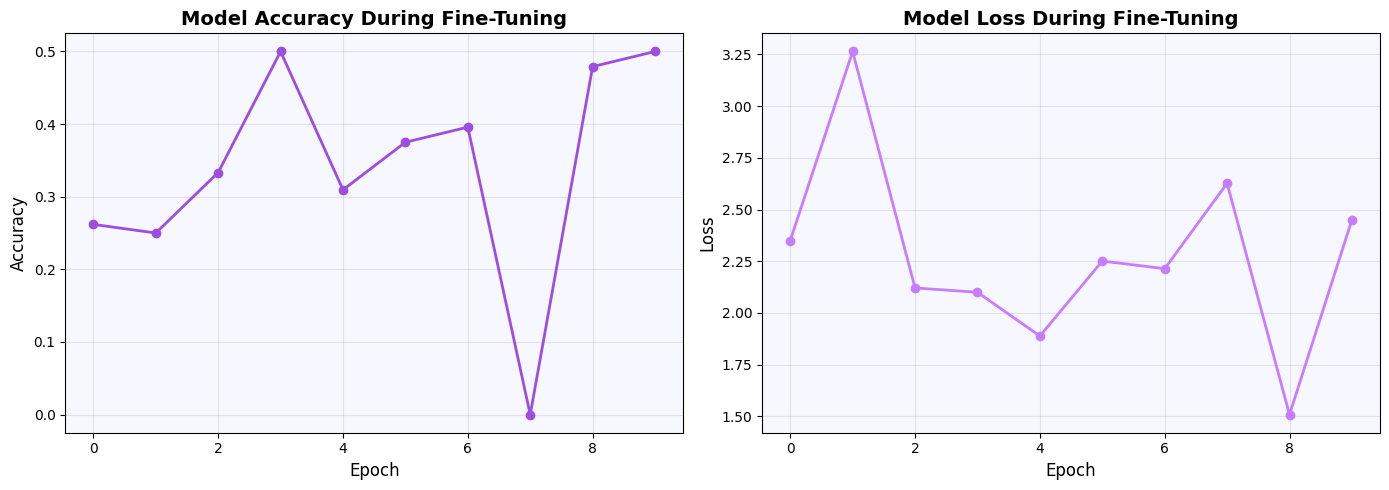


📊 Training Summary:
   Final Accuracy: 0.5000
   Final Loss: 2.4502


In [77]:
# Plot training progress
if 'history' not in locals() or history is None:
    print("⚠️ No training history available. Please run the training cell first.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    axes[0].plot(history.history['accuracy'], marker='o', linewidth=2, color='#9D4EDD')
    axes[0].set_title('Model Accuracy During Fine-Tuning', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_facecolor('#f7f7ff')

    # Plot loss
    axes[1].plot(history.history['loss'], marker='o', linewidth=2, color='#C77DFF')
    axes[1].set_title('Model Loss During Fine-Tuning', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_facecolor('#f7f7ff')

    plt.tight_layout()
    plt.show()

    print(f"\n📊 Training Summary:")
    print(f"   Final Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"   Final Loss: {history.history['loss'][-1]:.4f}")

## 💾 Save Retrained Model

Save the improved model.

In [78]:
# Evaluate on feedback data
if 'model' not in locals() or model is None or X is None or y is None:
    print("⚠️ Model or training data not available. Please run previous cells first.")
else:
    loss, accuracy = model.evaluate(X, y, verbose=0)
    print(f"📊 Evaluation on Feedback Data:")
    print(f"   Loss: {loss:.4f}")
    print(f"   Accuracy: {accuracy:.4f}")

📊 Evaluation on Feedback Data:
   Loss: 1.2432
   Accuracy: 0.6200


## 🔄 Replace Original Model (Automatic)

This step now automatically backs up the old model and replaces it with the retrained one.

**✅ Result:** Your Streamlit app will use `best_emotion_model.keras`, which is updated from the retrained model.

In [79]:
# Save and promote retrained model to active app model
if 'model' not in locals() or model is None:
    print("⚠️ No model available to save. Please run the training cells first.")
else:
    import shutil

    MODEL_BACKUP = os.path.join(BASE_DIR, "best_emotion_model_backup.keras")

    # 1) Save retrained model artifact
    model.save(RETRAINED_MODEL_PATH)
    print(f"✅ Retrained model saved to: {RETRAINED_MODEL_PATH}")

    # 2) Backup current active model (if present)
    if os.path.exists(MODEL_PATH):
        shutil.copy2(MODEL_PATH, MODEL_BACKUP)
        print(f"✅ Active model backed up to: {MODEL_BACKUP}")
    else:
        print(f"ℹ️ No existing active model found at: {MODEL_PATH}")

    # 3) Promote retrained model to active model used by app
    shutil.copy2(RETRAINED_MODEL_PATH, MODEL_PATH)
    print(f"✅ Active model updated: {MODEL_PATH}")

    # 4) Quick verification
    retrained_size = os.path.getsize(RETRAINED_MODEL_PATH)
    active_size = os.path.getsize(MODEL_PATH)
    if retrained_size == active_size:
        print("✅ Verification passed: active model matches retrained model size.")
    else:
        print("⚠️ Verification warning: file sizes differ, please re-check model files.")

    print("\n📝 Next Steps:")
    print("   1. Restart the Streamlit app if it is already running")
    print("   2. Test a few images to confirm improved predictions")
    print("   3. If needed, restore backup by copying backup -> best_emotion_model.keras")

✅ Retrained model saved to: c:\Users\moham\OneDrive\Desktop\AI-face-emotion-detaction\project\best_emotion_model_retrained.keras
✅ Active model backed up to: c:\Users\moham\OneDrive\Desktop\AI-face-emotion-detaction\project\best_emotion_model_backup.keras
✅ Active model updated: c:\Users\moham\OneDrive\Desktop\AI-face-emotion-detaction\project\best_emotion_model.keras
✅ Verification passed: active model matches retrained model size.

📝 Next Steps:
   1. Restart the Streamlit app if it is already running
   2. Test a few images to confirm improved predictions
   3. If needed, restore backup by copying backup -> best_emotion_model.keras


## 🎯 Summary

### What We Did:
1. ✅ Loaded feedback records from users
2. ✅ Visualized correction patterns and statistics
3. ✅ Fine-tuned the model with feedback data
4. ✅ Automatically promoted retrained model as active model

### How It Works:
- **Automatic Promotion**: The retrained model is automatically backed up and copied to `best_emotion_model.keras`
- **App Impact**: Your Streamlit app loads `best_emotion_model.keras`, so changes take effect immediately (restart app to reload)
- **Safe Rollback**: Previous version is saved in backup for quick restoration if needed

### Next Steps:
1. Restart the Streamlit app if it's running (Forces it to reload the updated model)
2. Test a few images to confirm improved emotion detection
3. Continue collecting feedback and retrain periodically (weekly/monthly) as more data accumulates
4. If needed, restore backup by copying `best_emotion_model_backup.keras` → `best_emotion_model.keras`

### Model Files:
- **best_emotion_model.keras** - Active model (loaded by app)
- **best_emotion_model_backup.keras** - Previous backup (for rollback)
- **best_emotion_model_retrained.keras** - Latest retrained artifact

---

**🚀 Ready to retrain again? Just re-run all cells!**